In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import yfinance as yf

In [12]:
msft = yf.Ticker('MSFT')
spy = yf.Ticker('SPY')

In [15]:
msft10yr = msft.history(start='2012-01-01', end='2022-01-01')[['Close']]
spy10yr = spy.history(start='2012-01-01', end='2022-01-01')[['Close']]

In [19]:
msft10yr['Close'][0]

21.572893142700195

In [25]:
msft10yr['PercentReturn(%)'] = round(((msft10yr['Close'] - msft10yr['Close'][0]) / msft10yr['Close'][0]) * 100, 2)

In [28]:
msft10yr.drop(columns='PercentReturn')

,Close,PercentReturn(%)
Date,,
2012-01-03,21.572893,0.00
2012-01-04,22.080585,2.35
2012-01-05,22.306223,3.40
2012-01-06,22.652748,5.01
2012-01-09,22.354576,3.62
...,...,...
2021-12-27,340.949280,1480.45
2021-12-28,339.754517,1474.91
2021-12-29,340.451477,1478.14


In [29]:
spy10yr['PercentReturn(%)'] = round(((spy10yr['Close'] - spy10yr['Close'][0]) / spy10yr['Close'][0]) * 100, 2)

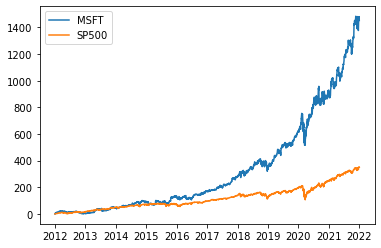

In [34]:
fig, ax = plt.subplots()

ax.plot(msft10yr['PercentReturn(%)'], label='MSFT')
ax.plot(spy10yr['PercentReturn(%)'], label='SP500')
ax.legend();

In [37]:
(msft10yr['PercentReturn(%)'][-1] < spy10yr['PercentReturn(%)'][-1]).astype('int')

0